In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from utils.utils import set_seed
set_seed()


from datetime import datetime, timedelta
from torch_geometric.nn import GATv2Conv, GATConv
from torch_geometric.utils import dense_to_sparse
from torch.distributions import Normal, Laplace, RelaxedOneHotCategorical
from torchdiffeq import odeint  # For continuous-time normalizing flows

from feature.scalers import ranged_scaler
from feature.engineering import *
from CARAT.model_utils import *
from CARAT.model import CausalGraphVAE
from CARAT.components import *
from utils.utils import set_seed, logger

# Torch settings
#torch.use_deterministic_algorithms(False)
#torch.backends.cudnn.benchmark = False
#torch.autograd.profiler.profile(enabled=False)
#torch.autograd.profiler.emit_nvtx(enabled=False)
#torch.autograd.set_detect_anomaly(mode=False)

# Environment variables
#os.environ['CUBLAS_WORKSPACE_CONFIG'] = '167772160'
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
#os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Set device
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
# Suppress warnings
warnings.filterwarnings('ignore')

# Load data
data = []
with open('data/TEP/idv1/y.dat', 'r') as file:
    for line in file:
        columns = line.strip().split("\t")
        data.append([float(col.strip()) for col in columns])


In [2]:
vars = len(data[0])
col_names = []
for i in  range(0,vars):
    col_names.append('x_'+str(i+1))
    

In [3]:
import polars as pl
from feature.scalers import ranged_scaler
df = pl.DataFrame(data,schema=col_names)
for col in df.columns:
    df = df.with_columns(ranged_scaler(df[col]))

In [4]:
df=df.to_pandas()

In [5]:
#random dates, trivial for this exercise

start_date = '2023-03-01'  # Define the start date
date_range = pd.date_range(start=start_date, periods=df.shape[0])

In [6]:
n_lags = most_frequent(find_optimal_lags_for_dataframe(df))+1

In [7]:
df['time']=date_range

<Axes: xlabel='None', ylabel='x_44'>

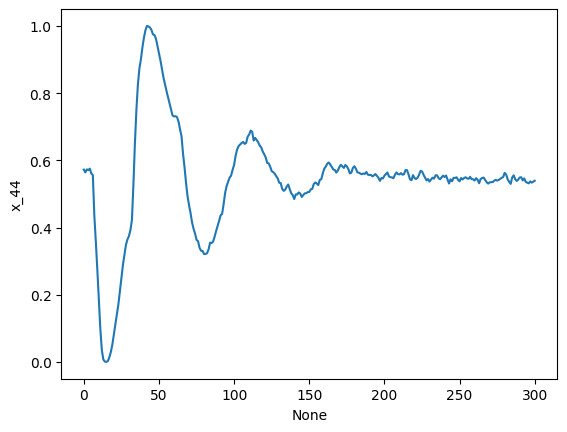

In [8]:
sns.lineplot(data=df,y='x_44',x=df.index)

In [9]:
df = df[['x_1', 'x_4','x_7','x_13','x_16','x_18','x_19','x_44','x_50']]

In [10]:
normal = df[200:]
bad = df[0:200]

In [11]:
df.columns

Index(['x_1', 'x_4', 'x_7', 'x_13', 'x_16', 'x_18', 'x_19', 'x_44', 'x_50'], dtype='object')

In [12]:
try:
    df = df.drop('time',axis=1)
except:
    None

try:
    normal = normal.drop('time',axis=1)
except:
    None
try:
    bad = bad.drop('time',axis=1)
except:
    None

In [13]:
cols = df.columns.tolist()

In [14]:
cols

['x_1', 'x_4', 'x_7', 'x_13', 'x_16', 'x_18', 'x_19', 'x_44', 'x_50']

# Pretraining

In [15]:
TIME_STEPS = 3
BATCH_SIZE = 100
hidden_dim = 256
latent_dim = 16
dataset_nominal = TimeSeriesDataset(normal, device=device, time_steps=TIME_STEPS)
dataloader_nominal = DataLoader(dataset_nominal, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model and optimizer
model = CausalGraphVAE(input_dim=normal.shape[1], hidden_dim=hidden_dim,
                        latent_dim=latent_dim, num_nodes=normal.shape[1],device=device,
                        time_steps=TIME_STEPS, prior_adj=None).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)

# Train on nominal data
#print("Pretraining on nominal data...")
model.train_model(dataloader_nominal, optimizer, num_epochs=250, patience=30,BATCH_SIZE=BATCH_SIZE,rho_max=5.0,alpha_max=2.5)

# Extract learned adjacency
prior_adj = model.causal_graph.adj_mat.clone().detach()
dataset_bad = TimeSeriesDataset(bad, device=device, time_steps=TIME_STEPS)
dataloader_bad = DataLoader(dataset_bad, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model and optimizer
fine_tuned = CausalGraphVAE(input_dim=bad.shape[1], hidden_dim=hidden_dim,
                        latent_dim=latent_dim, num_nodes=bad.shape[1],device=device,
                        time_steps=TIME_STEPS, prior_adj=prior_adj).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)

# Train on nominal data
# print("Pretraining on nominal data...")
fine_tuned.train_model(dataloader_nominal, optimizer, num_epochs=250, patience=30,BATCH_SIZE=BATCH_SIZE,rho_max=5.0,alpha_max=2.5)

X_data = torch.empty(0,device=device)
T_data = torch.empty(0,device=device)
for batch_idx, (X_batch, time_batch) in enumerate(dataloader_bad):
    X_data = torch.cat((X_data[:batch_idx], X_batch, X_data[batch_idx:]))
    T_data = torch.cat((T_data[:batch_idx], time_batch, T_data[batch_idx:]))


causes= fine_tuned.infer_causal_effect(X_data=X_data,T_data=T_data,target_variable='x_4',
                                       labels=cols,non_causal_indices=[],root_rank=False)
causes

Epoch 1: Loss = 812.0176
Recon Loss =778.9736, KL Loss = 0.0028, Sparsity Loss = 31.9106, Lagrangian Loss = 1.1306
Epoch 51: Loss = 41.0472
Recon Loss =6.0465, KL Loss = 1.2986, Sparsity Loss = 31.7032, Lagrangian Loss = 1.9989
Epoch 101: Loss = 38.9552
Recon Loss =2.6886, KL Loss = 1.6900, Sparsity Loss = 30.1271, Lagrangian Loss = 4.4494
Early stopping triggered. Last Epoch: 106
Recon Loss =2.6988, KL Loss = 1.7064, Sparsity Loss = 31.9658, Lagrangian Loss = 4.9728
Epoch 1: Loss = 957.2318
Recon Loss =906.3237, KL Loss = 0.0010, Sparsity Loss = 46.2988, Lagrangian Loss = 4.6082
Epoch 51: Loss = 959.3618
Recon Loss =906.2664, KL Loss = 0.0010, Sparsity Loss = 45.9023, Lagrangian Loss = 7.1921
Early stopping triggered. Last Epoch: 50
Recon Loss =906.2664, KL Loss = 0.0010, Sparsity Loss = 45.9023, Lagrangian Loss = 7.1921


,causes,instantaneous,lagged,counterfactuals,causal_strength,RootRank
x_44,0.986847,1.000000,0.851095,1.000000,0.959486,0.000000
x_16,0.930929,0.849648,0.900638,0.865319,0.886634,1.000000
x_18,1.000000,0.885855,1.000000,0.407225,0.823270,0.250000
x_13,0.925631,0.830610,0.910614,0.623310,0.822541,0.500001
x_1,0.906688,0.843386,0.859890,0.406988,0.754238,1.000000
x_19,0.917131,0.836309,0.887852,0.358308,0.749900,0.250000
x_50,0.840945,0.773637,0.808081,0.400123,0.705696,0.500001
x_7,0.830790,0.666767,0.903228,0.000000,0.600196,1.000000
x_4,0.000000,0.000000,0.000000,NaN,0.000000,0.500001


In [16]:
causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_16',cols,non_causal_indices=[])
causes

,causes,instantaneous,lagged,counterfactuals,causal_strength,RootRank
x_1,1.000000,0.998528,1.000000,1.000000,0.999632,0.800001
x_19,0.934715,0.978929,0.875572,0.244501,0.758429,0.800001
x_13,0.892575,0.804263,0.975344,0.234432,0.726653,0.000000
x_7,0.869936,0.910371,0.811402,0.300183,0.722973,1.000000
x_18,0.768353,0.654598,0.881077,0.585854,0.722470,0.199999
x_50,0.962413,1.000000,0.913646,0.000000,0.719015,0.800001
x_4,0.704574,0.697514,0.706220,0.578498,0.671702,0.400000
x_44,0.759935,0.632370,0.888331,0.168288,0.612231,0.800001
x_16,0.000000,0.000000,0.000000,NaN,0.000000,0.800001


In [17]:
causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_18',cols,non_causal_indices=[])
causes

,causes,instantaneous,lagged,counterfactuals,causal_strength,RootRank
x_1,0.891349,0.819792,0.933472,1.000000,0.911153,0.833333
x_13,0.978627,0.925689,1.000000,0.216933,0.780312,0.166666
x_4,1.000000,1.000000,0.962136,0.105441,0.766894,0.500000
x_44,0.851594,0.831360,0.836972,0.233039,0.688241,0.500000
x_50,0.829078,0.789980,0.837821,0.246023,0.675725,0.666667
x_16,0.747413,0.642100,0.840983,0.433467,0.665991,0.833333
x_19,0.809173,0.752627,0.839740,0.188805,0.647586,0.166666
x_7,0.728976,0.640734,0.805436,0.000000,0.543786,1.000000
x_18,0.000000,0.000000,0.000000,NaN,0.000000,0.000000


In [18]:
causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_13',cols,non_causal_indices=[])
causes

,causes,instantaneous,lagged,counterfactuals,causal_strength,RootRank
x_18,1.000000,1.000000,0.957178,1.000000,0.989295,0.200000
x_16,0.898710,0.800574,0.960227,0.844797,0.876077,0.600001
x_50,0.892453,0.752373,1.000000,0.582238,0.806766,1.000000
x_4,0.992083,0.986828,0.954328,0.201268,0.783627,0.000000
x_1,0.787409,0.659123,0.889742,0.640065,0.744085,0.600001
x_19,0.753080,0.696097,0.781515,0.741056,0.742937,0.800000
x_7,0.891952,0.820828,0.924130,0.242436,0.719836,0.200000
x_44,0.817288,0.714335,0.888939,0.000000,0.605141,0.200000
x_13,0.000000,0.000000,0.000000,NaN,0.000000,0.200000


In [19]:
causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_7',cols,non_causal_indices=[])
causes

,causes,instantaneous,lagged,counterfactuals,causal_strength,RootRank
x_13,0.825503,0.664498,0.999254,0.941166,0.857606,0.333334
x_44,0.801161,0.710129,0.896137,1.000000,0.851857,0.666668
x_19,0.938130,0.906247,0.966824,0.360217,0.792855,0.333334
x_16,1.000000,1.000000,1.000000,0.027664,0.756916,1.000000
x_50,0.964356,0.978478,0.943171,0.051425,0.734357,0.000000
x_1,0.823855,0.688635,0.968250,0.245522,0.681565,0.666668
x_18,0.818375,0.682921,0.963237,0.180999,0.661383,0.000000
x_4,0.744488,0.637451,0.861696,0.000000,0.560909,0.333334
x_7,0.000000,0.000000,0.000000,NaN,0.000000,0.333334


In [20]:
causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_50',cols,non_causal_indices=[])
causes

,causes,instantaneous,lagged,counterfactuals,causal_strength,RootRank
x_44,0.961420,0.917622,0.887055,1.000000,0.941524,0.333334
x_1,0.967311,0.820885,1.000000,0.719700,0.876974,1.000000
x_16,0.990340,1.000000,0.859592,0.483685,0.833405,0.333334
x_7,0.942138,0.915351,0.850888,0.619978,0.832089,0.666668
x_4,0.783484,0.643535,0.830614,0.984654,0.810572,0.000000
x_13,0.840715,0.643616,0.938086,0.480580,0.725749,0.000000
x_19,1.000000,0.977652,0.902757,0.000000,0.720102,0.000000
x_18,0.735578,0.667476,0.716956,0.594098,0.678527,0.333334
x_50,0.000000,0.000000,0.000000,NaN,0.000000,1.000000


In [21]:
causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_19',cols,non_causal_indices=[])
causes

,causes,instantaneous,lagged,counterfactuals,causal_strength,RootRank
x_7,0.961893,1.000000,0.873382,1.000000,0.958819,0.5
x_16,1.000000,0.996074,0.960963,0.438082,0.848780,1.0
x_44,0.883861,0.798047,0.932410,0.676671,0.822748,1.0
x_13,0.823898,0.824918,0.779730,0.685475,0.778505,0.0
x_18,0.876150,0.825482,0.886001,0.223015,0.702662,0.5
x_50,0.926100,0.816904,1.000000,0.000000,0.685751,1.0
x_1,0.803171,0.655575,0.925757,0.282268,0.666693,0.0
x_4,0.815935,0.760562,0.835017,0.032997,0.611128,0.5
x_19,0.000000,0.000000,0.000000,NaN,0.000000,1.0


In [24]:
TIME_STEPS = 3
BATCH_SIZE = 100
hidden_dim = 256
latent_dim = 16
edge_correct = 0
instantaneous_correct = 0
lagged_correct = 0
counterfactual_correct = 0 
rr_correct = 0
total_correct = 0
total_checked = 0
for i in range(30):
    total_checked+=1
    
    dataset_nominal = TimeSeriesDataset(normal, device=device, time_steps=TIME_STEPS)
    dataloader_nominal = DataLoader(dataset_nominal, batch_size=BATCH_SIZE, shuffle=False)
    
    # Initialize model and optimizer
    model = CausalGraphVAE(input_dim=normal.shape[1], hidden_dim=hidden_dim,
                            latent_dim=latent_dim, num_nodes=normal.shape[1],device=device,
                            time_steps=TIME_STEPS, prior_adj=None).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)
    
    # Train on nominal data
    #print("Pretraining on nominal data...")
    model.train_model(dataloader_nominal, optimizer, num_epochs=250, patience=30,BATCH_SIZE=BATCH_SIZE,rho_max=5.0,alpha_max=2.5)
    
    # Extract learned adjacency
    prior_adj = model.causal_graph.adj_mat.clone().detach()
    dataset_bad = TimeSeriesDataset(bad, device=device, time_steps=TIME_STEPS)
    dataloader_bad = DataLoader(dataset_bad, batch_size=BATCH_SIZE, shuffle=False)
    
    # Initialize model and optimizer
    fine_tuned = CausalGraphVAE(input_dim=bad.shape[1], hidden_dim=hidden_dim,
                            latent_dim=latent_dim, num_nodes=bad.shape[1],device=device,
                            time_steps=TIME_STEPS, prior_adj=prior_adj).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)
    
    # Train on nominal data
    # print("Pretraining on nominal data...")
    fine_tuned.train_model(dataloader_nominal, optimizer, num_epochs=250, patience=30,BATCH_SIZE=BATCH_SIZE,rho_max=5.0,alpha_max=2.5)
    
    X_data = torch.empty(0,device=device)
    T_data = torch.empty(0,device=device)
    for batch_idx, (X_batch, time_batch) in enumerate(dataloader_bad):
        X_data = torch.cat((X_data[:batch_idx], X_batch, X_data[batch_idx:]))
        T_data = torch.cat((T_data[:batch_idx], time_batch, T_data[batch_idx:]))
    
    causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_4',cols,non_causal_indices=[])
    
    edge_cause_1 = causes.sort_values(by='causes',ascending=False)[0:3].index[0]
    
    instant_cause_1 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[0]
    
    lag_cause_1 = causes.sort_values(by='lagged',ascending=False)[0:3].index[0]
    
    counterfactual_cause_1 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[0]
    
    rr_cause_1 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[0]
    
    total_score_cause_1=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[0]
    
    if edge_cause_1 in ['x_1','x_44']:
        edge_accuracy+=1
    
    if total_score_cause_1 in ['x_1','x_44']:
        total_correct+=1
    
    if counterfactual_cause_1 in ['x_1','x_44']:
        counterfactual_correct+=1
    
    if instant_cause_1 in ['x_1','x_44']:
        instant_accuracy+=1
    
    if lag_cause_1 in ['x_1','x_44']:
        lag_accuracy+=1
    
    if rr_cause_1 in ['x_1','x_44']:
        rr_accuracy+=1
        
    total_accuracy = total_correct/total_checked* 100
    edge_accuracy = edge_correct/total_checked* 100
    cf_accuracy = counterfactual_correct/total_checked* 100
    instant_accuracy = instantaneous_correct/total_checked* 100
    lag_accuracy = lagged_correct/total_checked* 100
    rr_accuracy = rr_correct/total_checked* 100
    
    
    logger.info(f"Edge Accuracy = {edge_accuracy:.2f}, Instantaneous Accuracy = {instant_accuracy:.2f}, Lagged Accuracy = {lag_accuracy:.2f}, Counterfactual Accuracy = {cf_accuracy:.2f},  Blended Accuracy = {total_accuracy:.2f},  RR Accuracy = {rr_accuracy:.2f}  ") 
    


Epoch 1: Loss = 923.4998
Recon Loss =890.8873, KL Loss = 0.0019, Sparsity Loss = 31.4590, Lagrangian Loss = 1.1515
Epoch 51: Loss = 41.7739
Recon Loss =5.6480, KL Loss = 1.4505, Sparsity Loss = 32.5400, Lagrangian Loss = 2.1353
Early stopping triggered. Last Epoch: 96
Recon Loss =2.7229, KL Loss = 1.7721, Sparsity Loss = 32.4096, Lagrangian Loss = 4.3704
Epoch 1: Loss = 918.2161
Recon Loss =865.8217, KL Loss = 0.0013, Sparsity Loss = 46.7983, Lagrangian Loss = 5.5948
Early stopping triggered. Last Epoch: 32
Recon Loss =875.9733, KL Loss = 0.0013, Sparsity Loss = 47.5186, Lagrangian Loss = 8.8703


2025-03-16 20:02:24,921 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 0.00,  Blended Accuracy = 0.00,  RR Accuracy = 0.00  


Epoch 1: Loss = 878.7849
Recon Loss =843.0634, KL Loss = 0.0028, Sparsity Loss = 34.4280, Lagrangian Loss = 1.2906
Epoch 51: Loss = 40.5325
Recon Loss =4.9073, KL Loss = 1.3818, Sparsity Loss = 32.0804, Lagrangian Loss = 2.1631
Early stopping triggered. Last Epoch: 91
Recon Loss =2.5790, KL Loss = 1.6878, Sparsity Loss = 32.6422, Lagrangian Loss = 4.2340
Epoch 1: Loss = 993.1023
Recon Loss =941.3853, KL Loss = 0.0017, Sparsity Loss = 46.7186, Lagrangian Loss = 4.9968
Early stopping triggered. Last Epoch: 37
Recon Loss =945.0339, KL Loss = 0.0017, Sparsity Loss = 48.1170, Lagrangian Loss = 9.0719


2025-03-16 20:02:35,853 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 50.00,  Blended Accuracy = 50.00,  RR Accuracy = 0.00  


Epoch 1: Loss = 926.6265
Recon Loss =892.6248, KL Loss = 0.0016, Sparsity Loss = 32.7710, Lagrangian Loss = 1.2292
Epoch 51: Loss = 40.9806
Recon Loss =5.2461, KL Loss = 1.4631, Sparsity Loss = 32.0113, Lagrangian Loss = 2.2602
Epoch 101: Loss = 40.2060
Recon Loss =2.6919, KL Loss = 1.7395, Sparsity Loss = 31.1549, Lagrangian Loss = 4.6197
Early stopping triggered. Last Epoch: 112
Recon Loss =2.5528, KL Loss = 1.7414, Sparsity Loss = 30.1439, Lagrangian Loss = 5.0405
Epoch 1: Loss = 827.1363
Recon Loss =772.1245, KL Loss = 0.0010, Sparsity Loss = 47.8742, Lagrangian Loss = 7.1366
Epoch 51: Loss = 842.0300
Recon Loss =783.5211, KL Loss = 0.0010, Sparsity Loss = 47.8572, Lagrangian Loss = 10.6506
Early stopping triggered. Last Epoch: 59
Recon Loss =783.7454, KL Loss = 0.0010, Sparsity Loss = 49.0185, Lagrangian Loss = 15.7857


2025-03-16 20:02:50,045 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 33.33,  Blended Accuracy = 33.33,  RR Accuracy = 0.00  


Epoch 1: Loss = 905.3773
Recon Loss =872.4228, KL Loss = 0.0020, Sparsity Loss = 31.8810, Lagrangian Loss = 1.0714
Epoch 51: Loss = 40.8056
Recon Loss =4.5568, KL Loss = 1.4449, Sparsity Loss = 32.5980, Lagrangian Loss = 2.2059
Epoch 101: Loss = 44.1699
Recon Loss =2.9032, KL Loss = 1.7724, Sparsity Loss = 34.0570, Lagrangian Loss = 5.4373
Early stopping triggered. Last Epoch: 102
Recon Loss =2.7664, KL Loss = 1.7827, Sparsity Loss = 32.6086, Lagrangian Loss = 5.0152
Epoch 1: Loss = 956.6114
Recon Loss =902.2981, KL Loss = 0.0027, Sparsity Loss = 48.0900, Lagrangian Loss = 6.2206
Epoch 51: Loss = 947.3044
Recon Loss =892.3737, KL Loss = 0.0027, Sparsity Loss = 46.9634, Lagrangian Loss = 7.9646
Early stopping triggered. Last Epoch: 78
Recon Loss =893.7354, KL Loss = 0.0027, Sparsity Loss = 48.0785, Lagrangian Loss = 15.5182


2025-03-16 20:03:04,773 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 50.00,  Blended Accuracy = 50.00,  RR Accuracy = 0.00  


Epoch 1: Loss = 890.1070
Recon Loss =856.6459, KL Loss = 0.0016, Sparsity Loss = 32.2697, Lagrangian Loss = 1.1897
Epoch 51: Loss = 41.1675
Recon Loss =5.3385, KL Loss = 1.3212, Sparsity Loss = 32.2307, Lagrangian Loss = 2.2772
Early stopping triggered. Last Epoch: 95
Recon Loss =2.7513, KL Loss = 1.7420, Sparsity Loss = 33.6718, Lagrangian Loss = 5.5852
Epoch 1: Loss = 831.4580
Recon Loss =780.9360, KL Loss = 0.0018, Sparsity Loss = 45.8495, Lagrangian Loss = 4.6707
Early stopping triggered. Last Epoch: 36
Recon Loss =784.5426, KL Loss = 0.0018, Sparsity Loss = 47.7606, Lagrangian Loss = 8.2353


2025-03-16 20:03:15,976 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 60.00,  Blended Accuracy = 40.00,  RR Accuracy = 0.00  


Epoch 1: Loss = 841.9304
Recon Loss =808.8258, KL Loss = 0.0013, Sparsity Loss = 31.9883, Lagrangian Loss = 1.1150
Epoch 51: Loss = 50.2270
Recon Loss =5.6433, KL Loss = 1.5076, Sparsity Loss = 39.3658, Lagrangian Loss = 3.7103
Early stopping triggered. Last Epoch: 93
Recon Loss =2.8754, KL Loss = 1.7719, Sparsity Loss = 38.7215, Lagrangian Loss = 6.4156
Epoch 1: Loss = 969.3032
Recon Loss =918.0578, KL Loss = 0.0021, Sparsity Loss = 45.9632, Lagrangian Loss = 5.2801
Early stopping triggered. Last Epoch: 46
Recon Loss =908.5320, KL Loss = 0.0021, Sparsity Loss = 46.8982, Lagrangian Loss = 8.3885


2025-03-16 20:03:27,693 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 50.00,  Blended Accuracy = 33.33,  RR Accuracy = 0.00  


Epoch 1: Loss = 875.2406
Recon Loss =840.0955, KL Loss = 0.0018, Sparsity Loss = 33.9680, Lagrangian Loss = 1.1754
Epoch 51: Loss = 39.3079
Recon Loss =5.0758, KL Loss = 1.3953, Sparsity Loss = 30.6926, Lagrangian Loss = 2.1443
Epoch 101: Loss = 39.4464
Recon Loss =2.6480, KL Loss = 1.7040, Sparsity Loss = 30.7252, Lagrangian Loss = 4.3693
Early stopping triggered. Last Epoch: 103
Recon Loss =2.4832, KL Loss = 1.7081, Sparsity Loss = 30.7341, Lagrangian Loss = 4.7751
Epoch 1: Loss = 844.8661
Recon Loss =791.2635, KL Loss = 0.0018, Sparsity Loss = 47.2989, Lagrangian Loss = 6.3019
Epoch 51: Loss = 857.1302
Recon Loss =800.4185, KL Loss = 0.0018, Sparsity Loss = 47.2428, Lagrangian Loss = 9.4671
Early stopping triggered. Last Epoch: 72
Recon Loss =795.2875, KL Loss = 0.0018, Sparsity Loss = 46.3382, Lagrangian Loss = 13.4572


2025-03-16 20:03:41,979 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 42.86,  Blended Accuracy = 28.57,  RR Accuracy = 0.00  


Epoch 1: Loss = 840.2360
Recon Loss =802.5753, KL Loss = 0.0016, Sparsity Loss = 36.0936, Lagrangian Loss = 1.5655
Epoch 51: Loss = 49.6155
Recon Loss =5.3922, KL Loss = 1.3427, Sparsity Loss = 39.6217, Lagrangian Loss = 3.2589
Epoch 101: Loss = 50.7452
Recon Loss =2.7812, KL Loss = 1.7439, Sparsity Loss = 39.0235, Lagrangian Loss = 7.1966
Early stopping triggered. Last Epoch: 107
Recon Loss =2.6965, KL Loss = 1.7700, Sparsity Loss = 39.3897, Lagrangian Loss = 8.2313
Epoch 1: Loss = 923.5396
Recon Loss =874.3195, KL Loss = 0.0017, Sparsity Loss = 45.0400, Lagrangian Loss = 4.1783
Early stopping triggered. Last Epoch: 42
Recon Loss =857.4957, KL Loss = 0.0017, Sparsity Loss = 46.9772, Lagrangian Loss = 7.2556


2025-03-16 20:03:54,527 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 37.50,  Blended Accuracy = 25.00,  RR Accuracy = 0.00  


Epoch 1: Loss = 934.5291
Recon Loss =901.6274, KL Loss = 0.0023, Sparsity Loss = 31.7918, Lagrangian Loss = 1.1076
Epoch 51: Loss = 41.4943
Recon Loss =5.6426, KL Loss = 1.4094, Sparsity Loss = 32.3187, Lagrangian Loss = 2.1236
Epoch 101: Loss = 40.2521
Recon Loss =2.7604, KL Loss = 1.7429, Sparsity Loss = 31.4017, Lagrangian Loss = 4.3471
Early stopping triggered. Last Epoch: 103
Recon Loss =2.6237, KL Loss = 1.7426, Sparsity Loss = 32.8277, Lagrangian Loss = 5.2648
Epoch 1: Loss = 915.8807
Recon Loss =865.0868, KL Loss = 0.0023, Sparsity Loss = 46.3941, Lagrangian Loss = 4.3975
Early stopping triggered. Last Epoch: 42
Recon Loss =846.5155, KL Loss = 0.0023, Sparsity Loss = 47.1467, Lagrangian Loss = 7.0558


2025-03-16 20:04:06,732 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 33.33,  Blended Accuracy = 33.33,  RR Accuracy = 0.00  


Epoch 1: Loss = 863.1340
Recon Loss =830.8285, KL Loss = 0.0021, Sparsity Loss = 31.2139, Lagrangian Loss = 1.0895
Epoch 51: Loss = 47.2375
Recon Loss =5.8485, KL Loss = 1.3688, Sparsity Loss = 36.7169, Lagrangian Loss = 3.3032
Epoch 101: Loss = 46.2776
Recon Loss =2.6912, KL Loss = 1.5992, Sparsity Loss = 35.9207, Lagrangian Loss = 6.0665
Early stopping triggered. Last Epoch: 113
Recon Loss =2.5388, KL Loss = 1.6230, Sparsity Loss = 35.8334, Lagrangian Loss = 7.3150
Epoch 1: Loss = 900.3804
Recon Loss =849.4302, KL Loss = 0.0018, Sparsity Loss = 46.3223, Lagrangian Loss = 4.6260
Early stopping triggered. Last Epoch: 41
Recon Loss =851.1674, KL Loss = 0.0018, Sparsity Loss = 48.1176, Lagrangian Loss = 8.9462


2025-03-16 20:04:19,750 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 30.00,  Blended Accuracy = 30.00,  RR Accuracy = 0.00  


Epoch 1: Loss = 855.3524
Recon Loss =818.4028, KL Loss = 0.0026, Sparsity Loss = 35.6631, Lagrangian Loss = 1.2838
Epoch 51: Loss = 45.5386
Recon Loss =5.1884, KL Loss = 1.5256, Sparsity Loss = 36.1081, Lagrangian Loss = 2.7165
Epoch 101: Loss = 45.7683
Recon Loss =2.6109, KL Loss = 1.6846, Sparsity Loss = 35.6364, Lagrangian Loss = 5.8365
Early stopping triggered. Last Epoch: 108
Recon Loss =2.6384, KL Loss = 1.6793, Sparsity Loss = 36.2646, Lagrangian Loss = 7.5474
Epoch 1: Loss = 883.4346
Recon Loss =829.9871, KL Loss = 0.0018, Sparsity Loss = 47.1090, Lagrangian Loss = 6.3368
Early stopping triggered. Last Epoch: 37
Recon Loss =838.4166, KL Loss = 0.0018, Sparsity Loss = 46.1628, Lagrangian Loss = 7.0517


2025-03-16 20:04:32,090 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 27.27,  Blended Accuracy = 36.36,  RR Accuracy = 0.00  


Epoch 1: Loss = 901.9230
Recon Loss =863.6213, KL Loss = 0.0016, Sparsity Loss = 36.8655, Lagrangian Loss = 1.4345
Epoch 51: Loss = 51.6679
Recon Loss =5.3093, KL Loss = 1.4441, Sparsity Loss = 40.7140, Lagrangian Loss = 4.2004
Early stopping triggered. Last Epoch: 85
Recon Loss =2.8550, KL Loss = 1.7437, Sparsity Loss = 38.4304, Lagrangian Loss = 5.5969
Epoch 1: Loss = 922.4103
Recon Loss =866.7642, KL Loss = 0.0015, Sparsity Loss = 47.9071, Lagrangian Loss = 7.7376
Early stopping triggered. Last Epoch: 30
Recon Loss =878.0331, KL Loss = 0.0015, Sparsity Loss = 49.1962, Lagrangian Loss = 10.5578


2025-03-16 20:04:41,993 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 25.00,  Blended Accuracy = 33.33,  RR Accuracy = 0.00  


Epoch 1: Loss = 858.7453
Recon Loss =824.4944, KL Loss = 0.0017, Sparsity Loss = 33.1061, Lagrangian Loss = 1.1431
Epoch 51: Loss = 40.0804
Recon Loss =5.5199, KL Loss = 1.3328, Sparsity Loss = 31.0893, Lagrangian Loss = 2.1384
Epoch 101: Loss = 41.3864
Recon Loss =2.7176, KL Loss = 1.6666, Sparsity Loss = 32.2124, Lagrangian Loss = 4.7897
Early stopping triggered. Last Epoch: 108
Recon Loss =2.5929, KL Loss = 1.6905, Sparsity Loss = 31.6962, Lagrangian Loss = 4.8084
Epoch 1: Loss = 967.6604
Recon Loss =917.4642, KL Loss = 0.0024, Sparsity Loss = 45.3500, Lagrangian Loss = 4.8437
Early stopping triggered. Last Epoch: 37
Recon Loss =922.6434, KL Loss = 0.0024, Sparsity Loss = 46.6008, Lagrangian Loss = 8.1263


2025-03-16 20:04:54,311 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 30.77,  Blended Accuracy = 38.46,  RR Accuracy = 0.00  


Epoch 1: Loss = 879.3340
Recon Loss =845.8203, KL Loss = 0.0015, Sparsity Loss = 32.3677, Lagrangian Loss = 1.1446
Epoch 51: Loss = 41.3710
Recon Loss =5.4378, KL Loss = 1.4960, Sparsity Loss = 32.1295, Lagrangian Loss = 2.3077
Epoch 101: Loss = 40.9696
Recon Loss =2.7183, KL Loss = 1.7817, Sparsity Loss = 31.9126, Lagrangian Loss = 4.5570
Early stopping triggered. Last Epoch: 108
Recon Loss =2.4799, KL Loss = 1.7954, Sparsity Loss = 30.3881, Lagrangian Loss = 4.7562
Epoch 1: Loss = 950.8910
Recon Loss =896.5814, KL Loss = 0.0022, Sparsity Loss = 47.9801, Lagrangian Loss = 6.3273
Early stopping triggered. Last Epoch: 49
Recon Loss =898.5336, KL Loss = 0.0022, Sparsity Loss = 48.7161, Lagrangian Loss = 11.4209


2025-03-16 20:05:07,397 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 28.57,  Blended Accuracy = 35.71,  RR Accuracy = 0.00  


Epoch 1: Loss = 909.8593
Recon Loss =875.2949, KL Loss = 0.0016, Sparsity Loss = 33.3990, Lagrangian Loss = 1.1636
Epoch 51: Loss = 43.0127
Recon Loss =5.2529, KL Loss = 1.5247, Sparsity Loss = 33.7762, Lagrangian Loss = 2.4589
Early stopping triggered. Last Epoch: 93
Recon Loss =2.6687, KL Loss = 1.7257, Sparsity Loss = 33.1848, Lagrangian Loss = 4.2070
Epoch 1: Loss = 899.1845
Recon Loss =848.9702, KL Loss = 0.0032, Sparsity Loss = 45.5992, Lagrangian Loss = 4.6118
Epoch 51: Loss = 900.0093
Recon Loss =844.0300, KL Loss = 0.0032, Sparsity Loss = 47.2152, Lagrangian Loss = 8.7609
Early stopping triggered. Last Epoch: 99
Recon Loss =833.2592, KL Loss = 0.0032, Sparsity Loss = 47.8891, Lagrangian Loss = 19.0746


2025-03-16 20:05:22,602 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 26.67,  Blended Accuracy = 33.33,  RR Accuracy = 0.00  


Epoch 1: Loss = 909.3013
Recon Loss =875.3792, KL Loss = 0.0020, Sparsity Loss = 32.7547, Lagrangian Loss = 1.1654
Epoch 51: Loss = 40.9382
Recon Loss =6.6259, KL Loss = 1.5234, Sparsity Loss = 30.6783, Lagrangian Loss = 2.1106
Epoch 101: Loss = 38.9720
Recon Loss =2.7011, KL Loss = 1.7201, Sparsity Loss = 30.4240, Lagrangian Loss = 4.1268
Early stopping triggered. Last Epoch: 115
Recon Loss =2.5279, KL Loss = 1.7243, Sparsity Loss = 30.9768, Lagrangian Loss = 5.6410
Epoch 1: Loss = 933.3649
Recon Loss =880.5051, KL Loss = 0.0029, Sparsity Loss = 47.2057, Lagrangian Loss = 5.6513
Early stopping triggered. Last Epoch: 32
Recon Loss =876.2397, KL Loss = 0.0029, Sparsity Loss = 46.5272, Lagrangian Loss = 7.3644


2025-03-16 20:05:35,175 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 25.00,  Blended Accuracy = 31.25,  RR Accuracy = 0.00  


Epoch 1: Loss = 873.6434
Recon Loss =834.3834, KL Loss = 0.0017, Sparsity Loss = 37.5774, Lagrangian Loss = 1.6809
Epoch 51: Loss = 40.2550
Recon Loss =5.3760, KL Loss = 1.5750, Sparsity Loss = 31.1303, Lagrangian Loss = 2.1737
Epoch 101: Loss = 40.9609
Recon Loss =2.5708, KL Loss = 1.7713, Sparsity Loss = 31.9985, Lagrangian Loss = 4.6204
Early stopping triggered. Last Epoch: 112
Recon Loss =2.5335, KL Loss = 1.7506, Sparsity Loss = 31.5012, Lagrangian Loss = 5.3507
Epoch 1: Loss = 876.7759
Recon Loss =823.0110, KL Loss = 0.0016, Sparsity Loss = 47.6653, Lagrangian Loss = 6.0980
Epoch 51: Loss = 890.7977
Recon Loss =831.5353, KL Loss = 0.0016, Sparsity Loss = 48.2298, Lagrangian Loss = 11.0309
Early stopping triggered. Last Epoch: 57
Recon Loss =829.0507, KL Loss = 0.0016, Sparsity Loss = 46.2990, Lagrangian Loss = 8.0260


2025-03-16 20:05:49,227 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 23.53,  Blended Accuracy = 29.41,  RR Accuracy = 0.00  


Epoch 1: Loss = 892.4432
Recon Loss =859.5954, KL Loss = 0.0019, Sparsity Loss = 31.7525, Lagrangian Loss = 1.0934
Epoch 51: Loss = 46.0836
Recon Loss =6.1766, KL Loss = 1.4314, Sparsity Loss = 35.8541, Lagrangian Loss = 2.6214
Early stopping triggered. Last Epoch: 91
Recon Loss =2.7210, KL Loss = 1.7484, Sparsity Loss = 35.5812, Lagrangian Loss = 5.1969
Epoch 1: Loss = 871.7120
Recon Loss =820.8953, KL Loss = 0.0020, Sparsity Loss = 46.2915, Lagrangian Loss = 4.5232
Early stopping triggered. Last Epoch: 38
Recon Loss =818.6424, KL Loss = 0.0020, Sparsity Loss = 47.2512, Lagrangian Loss = 7.3186


2025-03-16 20:06:00,177 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 22.22,  Blended Accuracy = 27.78,  RR Accuracy = 0.00  


Epoch 1: Loss = 878.7724
Recon Loss =846.8163, KL Loss = 0.0024, Sparsity Loss = 30.8997, Lagrangian Loss = 1.0540
Epoch 51: Loss = 41.1206
Recon Loss =5.2911, KL Loss = 1.5194, Sparsity Loss = 32.0742, Lagrangian Loss = 2.2359
Epoch 101: Loss = 40.3483
Recon Loss =2.5595, KL Loss = 1.8078, Sparsity Loss = 31.2141, Lagrangian Loss = 4.7669
Early stopping triggered. Last Epoch: 105
Recon Loss =2.6409, KL Loss = 1.8169, Sparsity Loss = 32.0379, Lagrangian Loss = 5.1528
Epoch 1: Loss = 931.2455
Recon Loss =876.9354, KL Loss = 0.0030, Sparsity Loss = 47.6057, Lagrangian Loss = 6.7014
Early stopping triggered. Last Epoch: 46
Recon Loss =881.3325, KL Loss = 0.0030, Sparsity Loss = 46.9416, Lagrangian Loss = 8.2929


2025-03-16 20:06:12,828 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 21.05,  Blended Accuracy = 26.32,  RR Accuracy = 0.00  


Epoch 1: Loss = 909.8478
Recon Loss =875.6581, KL Loss = 0.0013, Sparsity Loss = 33.0251, Lagrangian Loss = 1.1634
Epoch 51: Loss = 41.1569
Recon Loss =5.1895, KL Loss = 1.4816, Sparsity Loss = 32.2106, Lagrangian Loss = 2.2751
Early stopping triggered. Last Epoch: 97
Recon Loss =2.7405, KL Loss = 1.7989, Sparsity Loss = 33.2082, Lagrangian Loss = 4.8224
Epoch 1: Loss = 955.3694
Recon Loss =899.0122, KL Loss = 0.0017, Sparsity Loss = 48.5280, Lagrangian Loss = 7.8274
Epoch 51: Loss = 939.1556
Recon Loss =878.5205, KL Loss = 0.0017, Sparsity Loss = 48.6242, Lagrangian Loss = 12.0092
Early stopping triggered. Last Epoch: 63
Recon Loss =899.0678, KL Loss = 0.0017, Sparsity Loss = 50.5123, Lagrangian Loss = 20.6297


2025-03-16 20:06:26,032 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 25.00,  Blended Accuracy = 30.00,  RR Accuracy = 0.00  


Epoch 1: Loss = 875.4210
Recon Loss =841.7144, KL Loss = 0.0017, Sparsity Loss = 32.5383, Lagrangian Loss = 1.1666
Epoch 51: Loss = 43.3647
Recon Loss =8.3661, KL Loss = 1.2343, Sparsity Loss = 31.5382, Lagrangian Loss = 2.2262
Epoch 101: Loss = 39.1204
Recon Loss =2.7111, KL Loss = 1.6585, Sparsity Loss = 30.3907, Lagrangian Loss = 4.3601
Early stopping triggered. Last Epoch: 105
Recon Loss =2.6056, KL Loss = 1.6833, Sparsity Loss = 31.4299, Lagrangian Loss = 5.2155
Epoch 1: Loss = 894.6659
Recon Loss =846.4778, KL Loss = 0.0024, Sparsity Loss = 44.8926, Lagrangian Loss = 3.2931
Early stopping triggered. Last Epoch: 33
Recon Loss =841.3287, KL Loss = 0.0024, Sparsity Loss = 46.8879, Lagrangian Loss = 6.0411


2025-03-16 20:06:37,853 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 23.81,  Blended Accuracy = 33.33,  RR Accuracy = 0.00  


Epoch 1: Loss = 898.9993
Recon Loss =863.6127, KL Loss = 0.0012, Sparsity Loss = 34.1407, Lagrangian Loss = 1.2449
Epoch 51: Loss = 41.0342
Recon Loss =5.3354, KL Loss = 1.4789, Sparsity Loss = 32.0537, Lagrangian Loss = 2.1663
Epoch 101: Loss = 40.7200
Recon Loss =2.7536, KL Loss = 1.8550, Sparsity Loss = 31.5759, Lagrangian Loss = 4.5354
Early stopping triggered. Last Epoch: 132
Recon Loss =2.5451, KL Loss = 1.8351, Sparsity Loss = 32.3550, Lagrangian Loss = 7.0328
Epoch 1: Loss = 918.7467
Recon Loss =864.5929, KL Loss = 0.0025, Sparsity Loss = 47.9593, Lagrangian Loss = 6.1921
Epoch 51: Loss = 911.8880
Recon Loss =860.0375, KL Loss = 0.0025, Sparsity Loss = 45.3940, Lagrangian Loss = 6.4540
Early stopping triggered. Last Epoch: 71
Recon Loss =870.1113, KL Loss = 0.0025, Sparsity Loss = 45.2969, Lagrangian Loss = 8.8084


2025-03-16 20:06:54,537 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 22.73,  Blended Accuracy = 36.36,  RR Accuracy = 0.00  


Epoch 1: Loss = 907.8540
Recon Loss =874.1597, KL Loss = 0.0015, Sparsity Loss = 32.4868, Lagrangian Loss = 1.2060
Epoch 51: Loss = 41.5718
Recon Loss =4.5531, KL Loss = 1.4343, Sparsity Loss = 33.1504, Lagrangian Loss = 2.4340
Early stopping triggered. Last Epoch: 94
Recon Loss =2.6051, KL Loss = 1.7450, Sparsity Loss = 32.4789, Lagrangian Loss = 4.4301
Epoch 1: Loss = 889.0469
Recon Loss =835.1943, KL Loss = 0.0024, Sparsity Loss = 47.6881, Lagrangian Loss = 6.1620
Early stopping triggered. Last Epoch: 42
Recon Loss =844.3776, KL Loss = 0.0024, Sparsity Loss = 48.7424, Lagrangian Loss = 10.7391


2025-03-16 20:07:06,420 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 21.74,  Blended Accuracy = 34.78,  RR Accuracy = 0.00  


Epoch 1: Loss = 889.7897
Recon Loss =857.1315, KL Loss = 0.0023, Sparsity Loss = 31.5380, Lagrangian Loss = 1.1179
Epoch 51: Loss = 42.8229
Recon Loss =6.9363, KL Loss = 1.2825, Sparsity Loss = 32.3111, Lagrangian Loss = 2.2929
Epoch 101: Loss = 39.6809
Recon Loss =2.6374, KL Loss = 1.7097, Sparsity Loss = 30.7051, Lagrangian Loss = 4.6287
Early stopping triggered. Last Epoch: 103
Recon Loss =2.6617, KL Loss = 1.7079, Sparsity Loss = 31.9455, Lagrangian Loss = 4.9028
Epoch 1: Loss = 919.2493
Recon Loss =867.1156, KL Loss = 0.0022, Sparsity Loss = 46.7549, Lagrangian Loss = 5.3766
Early stopping triggered. Last Epoch: 42
Recon Loss =855.1924, KL Loss = 0.0022, Sparsity Loss = 46.7708, Lagrangian Loss = 7.4420


2025-03-16 20:07:19,430 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 20.83,  Blended Accuracy = 37.50,  RR Accuracy = 0.00  


Epoch 1: Loss = 844.5327
Recon Loss =813.1517, KL Loss = 0.0025, Sparsity Loss = 30.3338, Lagrangian Loss = 1.0448
Epoch 51: Loss = 40.1945
Recon Loss =5.4774, KL Loss = 1.4111, Sparsity Loss = 31.1752, Lagrangian Loss = 2.1307
Epoch 101: Loss = 39.9458
Recon Loss =2.7127, KL Loss = 1.8513, Sparsity Loss = 30.6763, Lagrangian Loss = 4.7056
Early stopping triggered. Last Epoch: 100
Recon Loss =2.7127, KL Loss = 1.8513, Sparsity Loss = 30.6763, Lagrangian Loss = 4.7056
Epoch 1: Loss = 954.9221
Recon Loss =902.9885, KL Loss = 0.0017, Sparsity Loss = 46.6917, Lagrangian Loss = 5.2403
Early stopping triggered. Last Epoch: 32
Recon Loss =894.7676, KL Loss = 0.0017, Sparsity Loss = 48.6270, Lagrangian Loss = 8.8861


2025-03-16 20:07:31,506 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 20.00,  Blended Accuracy = 36.00,  RR Accuracy = 0.00  


Epoch 1: Loss = 830.2301
Recon Loss =797.1202, KL Loss = 0.0029, Sparsity Loss = 31.9800, Lagrangian Loss = 1.1271
Epoch 51: Loss = 42.0372
Recon Loss =5.6403, KL Loss = 1.4386, Sparsity Loss = 32.6727, Lagrangian Loss = 2.2856
Early stopping triggered. Last Epoch: 95
Recon Loss =2.7069, KL Loss = 1.7008, Sparsity Loss = 33.0388, Lagrangian Loss = 4.7228
Epoch 1: Loss = 868.8365
Recon Loss =815.9921, KL Loss = 0.0028, Sparsity Loss = 47.4210, Lagrangian Loss = 5.4205
Epoch 51: Loss = 872.9104
Recon Loss =816.8434, KL Loss = 0.0028, Sparsity Loss = 47.0055, Lagrangian Loss = 9.0587
Early stopping triggered. Last Epoch: 54
Recon Loss =797.2256, KL Loss = 0.0028, Sparsity Loss = 47.2838, Lagrangian Loss = 9.5417


2025-03-16 20:07:43,880 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 23.08,  Blended Accuracy = 38.46,  RR Accuracy = 0.00  


Epoch 1: Loss = 907.5587
Recon Loss =871.9923, KL Loss = 0.0018, Sparsity Loss = 34.3453, Lagrangian Loss = 1.2193
Epoch 51: Loss = 40.1669
Recon Loss =6.0555, KL Loss = 1.6061, Sparsity Loss = 30.5689, Lagrangian Loss = 1.9363
Early stopping triggered. Last Epoch: 88
Recon Loss =2.5710, KL Loss = 1.8603, Sparsity Loss = 31.0508, Lagrangian Loss = 3.8897
Epoch 1: Loss = 939.1154
Recon Loss =885.8948, KL Loss = 0.0014, Sparsity Loss = 47.8150, Lagrangian Loss = 5.4041
Epoch 51: Loss = 939.7333
Recon Loss =886.4575, KL Loss = 0.0014, Sparsity Loss = 46.3425, Lagrangian Loss = 6.9319
Early stopping triggered. Last Epoch: 63
Recon Loss =884.2687, KL Loss = 0.0014, Sparsity Loss = 44.7629, Lagrangian Loss = 6.7763


2025-03-16 20:07:56,388 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 22.22,  Blended Accuracy = 37.04,  RR Accuracy = 0.00  


Epoch 1: Loss = 886.7258
Recon Loss =852.4958, KL Loss = 0.0013, Sparsity Loss = 33.0180, Lagrangian Loss = 1.2106
Epoch 51: Loss = 42.4492
Recon Loss =5.4465, KL Loss = 1.5588, Sparsity Loss = 33.0393, Lagrangian Loss = 2.4045
Early stopping triggered. Last Epoch: 95
Recon Loss =2.7764, KL Loss = 1.8041, Sparsity Loss = 33.3566, Lagrangian Loss = 4.6726
Epoch 1: Loss = 905.2235
Recon Loss =853.9166, KL Loss = 0.0021, Sparsity Loss = 46.4522, Lagrangian Loss = 4.8527
Early stopping triggered. Last Epoch: 30
Recon Loss =862.0961, KL Loss = 0.0021, Sparsity Loss = 46.5417, Lagrangian Loss = 6.3654


2025-03-16 20:08:07,187 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 21.43,  Blended Accuracy = 35.71,  RR Accuracy = 0.00  


Epoch 1: Loss = 867.5835
Recon Loss =833.6240, KL Loss = 0.0020, Sparsity Loss = 32.8253, Lagrangian Loss = 1.1321
Epoch 51: Loss = 40.1677
Recon Loss =4.6441, KL Loss = 1.4750, Sparsity Loss = 31.8929, Lagrangian Loss = 2.1557
Epoch 101: Loss = 41.1448
Recon Loss =2.6186, KL Loss = 1.8381, Sparsity Loss = 31.9282, Lagrangian Loss = 4.7598
Early stopping triggered. Last Epoch: 109
Recon Loss =2.5865, KL Loss = 1.8471, Sparsity Loss = 31.5935, Lagrangian Loss = 5.1745
Epoch 1: Loss = 917.4636
Recon Loss =863.6752, KL Loss = 0.0014, Sparsity Loss = 47.6614, Lagrangian Loss = 6.1256
Early stopping triggered. Last Epoch: 41
Recon Loss =855.3022, KL Loss = 0.0014, Sparsity Loss = 49.0191, Lagrangian Loss = 11.0139


2025-03-16 20:08:19,855 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 20.69,  Blended Accuracy = 34.48,  RR Accuracy = 0.00  


Epoch 1: Loss = 957.5738
Recon Loss =921.5117, KL Loss = 0.0019, Sparsity Loss = 34.8030, Lagrangian Loss = 1.2572
Epoch 51: Loss = 46.5995
Recon Loss =5.3524, KL Loss = 1.4126, Sparsity Loss = 36.7720, Lagrangian Loss = 3.0625


KeyboardInterrupt: 